# Comparing Random and Same sampling strategies in EpiOS

## Introduction

In this notebook, we compare the following two strategies in EpiOS:

- Random

    This strategy samples individuals by choosing a random subset of people for each time step.

- Same

    This strategy follows the same people over the course of the epidemic.

### Imports

In [1]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Collecting data from pyEpiabm
This notebook takes data from the gibraltar_example of pyEpiabm (see `README.md` in the current directory).

This simulation was run over 365 days with a total population of 33078. Additionally, this data has the
new waning immunity features, so we get waves of infections. See the SIR plot below.

## SIR Plot for Gibraltar
![SIR Plot](simulation_outputs/simulation_flow_SIR_plot.png)

We ran the above simulation with no interventions, and so the number of infected forms waves and does not appear to decrease
over time.

### Accessing the data

In [2]:
path = '.'
# This assumes the python venv is installed under epios folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

### Using `epios.PostProcess` to generate a single prediction

Given a specific `sample_strategy`, we can get a prediction using the `Base` method from `epios.PostProcess`.

In [3]:
def predict_base(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Base` method from `epios.PostProcess` to plot and predict
    incidence rate from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Base(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, prediction = result[0], np.array(result[1]) * pop_size
    true = diff + prediction

    return times, true, prediction

### Finding samples using both Random and Same strategies

In [4]:
def rand_and_same(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the Random and Same sampling strategies,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy and
        predictions with Same strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    base_random = predict_base(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, pred_random = base_random

    # Do prediction and comparison with Same sampling strategy - this tracks
    # the same people every time step
    pred_same = predict_base(post_process=post_process,
                             sample_size=sample_size,
                             time_sample=time_sample,
                             comparison=comparison,
                             sample_strategy='Same')[2]

    return times, true, pred_random, pred_same

## Sampling

Here, we take multiple samples using both strategies.

### Initialising the post process

In [5]:
post_process = epios.PostProcess(demo_data=demo_data, time_data=time_data)

# Initialise the random_predictions, same_predictions and RMSEs
random_predictions = []
same_predictions = []
random_rmses = []
same_rmses = []

### Running the Random and Same strategies multiple times
We run them for `num_iters` iterations so that we can average over the results. We also choose to take `sample_size=100` and 
`time_sample=[0, ..., 299]` to see the full effects of waning immunity.

In [6]:
num_iters = 50
for j in range(num_iters):
    predictions = rand_and_same(post_process=post_process,
                                sample_size=100,
                                time_sample=list(range(300)),
                                comparison=True)
    times, true, pred_random, pred_same = predictions
    random_predictions.append(pred_random)
    same_predictions.append(pred_same)

    rmse_random = np.sqrt(((true - pred_random) ** 2).mean())
    rmse_same = np.sqrt(((true - pred_same) ** 2).mean())
    random_rmses.append(rmse_random)
    same_rmses.append(rmse_same)
    print(f"Iteration {j}")
    print(f"Root mean squared error for random sampling: {rmse_random}")
    print(f"Root mean squared error for same sampling: {rmse_same}")

Iteration 0
Root mean squared error for random sampling: 1332.211867495557
Root mean squared error for same sampling: 1236.1637816794344
Iteration 1
Root mean squared error for random sampling: 1361.0576153535897
Root mean squared error for same sampling: 1409.7917389160714
Iteration 2
Root mean squared error for random sampling: 1286.1500917202472
Root mean squared error for same sampling: 1249.4410719005518
Iteration 3
Root mean squared error for random sampling: 1266.4237945079838
Root mean squared error for same sampling: 1334.0028981557725
Iteration 4
Root mean squared error for random sampling: 1292.6059870989302
Root mean squared error for same sampling: 1490.9097441508657
Iteration 5
Root mean squared error for random sampling: 1267.8607725929533
Root mean squared error for same sampling: 1222.0451345314543
Iteration 6
Root mean squared error for random sampling: 1291.0430014294645
Root mean squared error for same sampling: 1061.1568286016916
Iteration 7
Root mean squared error

### Finding means and standard deviations

In [7]:
# Get large arrays with all predictions
random_array = np.array(random_predictions)
same_array = np.array(same_predictions)

# Find their means and standard deviations
mean_random_array = np.mean(random_array, axis=0)
mean_same_array = np.mean(same_array, axis=0)
std_dev_random_array = np.std(random_array, axis=0)
std_dev_same_array = np.std(same_array, axis=0)

random_rmse_array = np.array(random_rmses)
same_rmse_array = np.array(same_rmses)
print(f"Overall root mean squared error for random sampling: {np.mean(random_rmse_array)}")
print(f"Overall root mean squared error for same sampling: {np.mean(same_rmse_array)}")

Overall root mean squared error for random sampling: 1312.7176927643516
Overall root mean squared error for same sampling: 1302.968885832793


### Saving to .csv files

In [8]:
random_df = pd.DataFrame(random_array, columns=list(times))
same_df = pd.DataFrame(same_array, columns=list(times))
random_df.to_csv('sampling/random_strategy/predictions.csv')
same_df.to_csv('sampling/same_strategy/predictions.csv')

## Plotting

These plots mimic the ones produced in EpiOS, but here we are using the arrays averaged over a number
of iterations.

### Random strategy

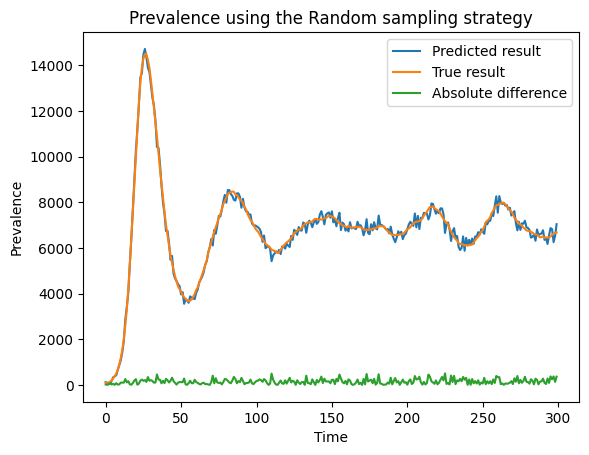

<Figure size 640x480 with 0 Axes>

In [9]:
legend = {"Predicted result": mean_random_array, "True result": true, 
          "Absolute difference": np.abs(mean_random_array - true)}

for label in legend.keys():
    plt.plot(times, legend[label], label=label)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.legend()
plt.title("Prevalence using the Random sampling strategy")
plt.savefig("sampling/random_strategy/comparison.png")
plt.show()
plt.clf()

### Same strategy

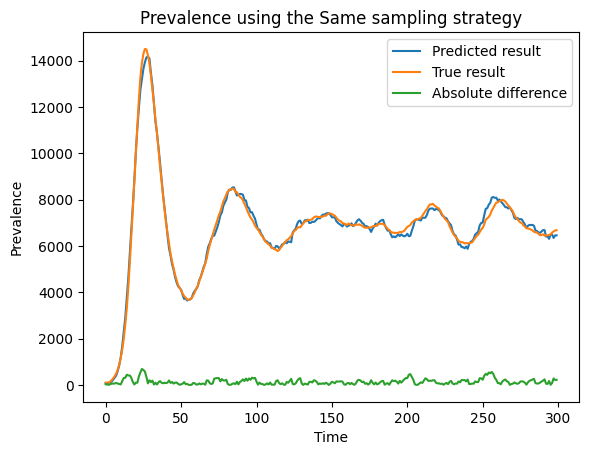

<Figure size 640x480 with 0 Axes>

In [10]:
legend = {"Predicted result": mean_same_array, "True result": true, 
          "Absolute difference": np.abs(mean_same_array - true)}

for label in legend.keys():
    plt.plot(times, legend[label], label=label)
plt.xlabel("Time")
plt.ylabel("Prevalence")
plt.legend()
plt.title("Prevalence using the Same sampling strategy")
plt.savefig("sampling/random_strategy/comparison.png")
plt.show()
plt.clf()

### Plotting RMSEs for the different strategies

Here we plot the root mean squared errors away from the true prevalence for Random vs Same sampling as 
two histograms, to provide a comparison.

In [11]:
rmse_df = pd.DataFrame(np.array([random_rmse_array, same_rmse_array]).transpose(), 
                       columns=['Random strategy RMSE', 'Same strategy RMSE'])

<Axes: ylabel='Frequency'>

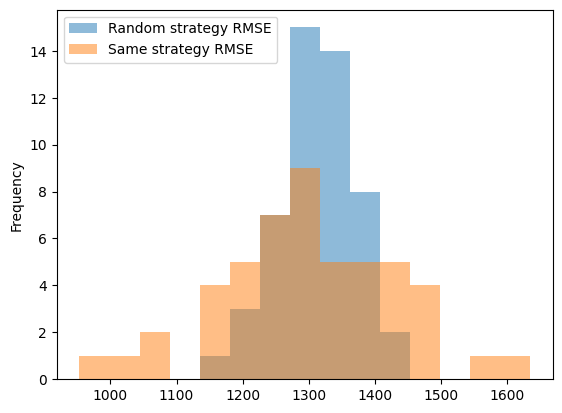

In [15]:
rmse_df.plot.hist(bins=15, alpha=0.5)

## Analysis

We see that both strategies perform reasonably well when averaging over the `num_iters`. However, the Random sampling
strategy appears to be noisier, particularly at later times when the natural immunity of the population begins to wane and
the second wave of infections begins. We do not see this effect using the Same sampling strategy to the same extent.

This implies that following the same people over a simulation may improve the quality of the sampling. Furthermore, this may
lead to better results later in the simulation, where the same individuals get re-sampled after catching the disease a second
or third time.

The RMSE histograms show an interesting pattern, with a very narrow distribution for the Random strategy but a much wider
distribution for the Same strategy. One potential reason for this would be that certain people represent the population as
a whole a lot better. In particular, if we track people who are reinfected multiple times then this will more likely reflect
the true population.